# Automatic Manifold Alignment
## Team LeakSeek

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cv2 as cv
import scipy.spatial as sp

### Constants

In [1]:
# File Paths
MANIFOLD_IMG_PATH = 'manifolds/manifold3.png'

### Read Manifold and Reference Feature Images

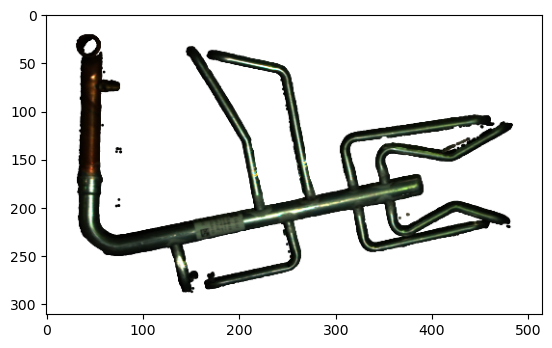

In [3]:
manifold_orig = cv.imread(MANIFOLD_IMG_PATH)
manifold_orig = cv.cvtColor(manifold_orig, cv.COLOR_BGR2RGB)
plt.imshow(manifold_orig)

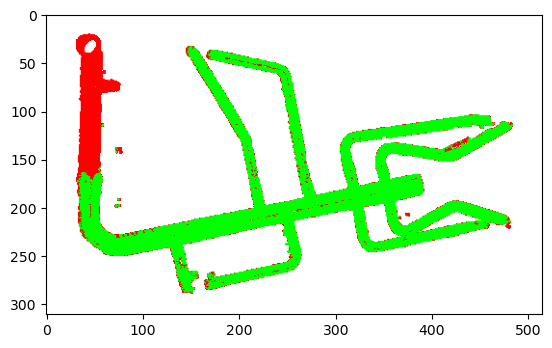

In [4]:
# Color Segmentation

#Stored all RGB values of main colors in a array
# *********Possibly determine these colors by making the user mainly select different colors in the image when
#   creating feature image.********
main_colors = [(255,0,0), (0, 255, 0)] 

image = manifold_orig.copy()
#convert BGR to RGB image
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

h,w,bpp = np.shape(image)

#Change colors of each pixel
#reference :https://stackoverflow.com/a/48884514/9799700
for py in range(0,h):
    for px in range(0,w):
        color = tuple(list(image[py][px]))
        if color == (255, 255, 255):
            continue
        
        ########################
        #Used this part to find nearest color 
        #reference : https://stackoverflow.com/a/22478139/9799700
        input_color = (image[py][px][0],image[py][px][1],image[py][px][2])
        tree = sp.KDTree(main_colors) 
        ditsance, result = tree.query(input_color) 
        nearest_color = main_colors[result]
        ###################

        image[py][px][0]=nearest_color[0]
        image[py][px][1]=nearest_color[1]
        image[py][px][2]=nearest_color[2]

# show image
plt.figure()
plt.imshow(image)

 Progress: 100%

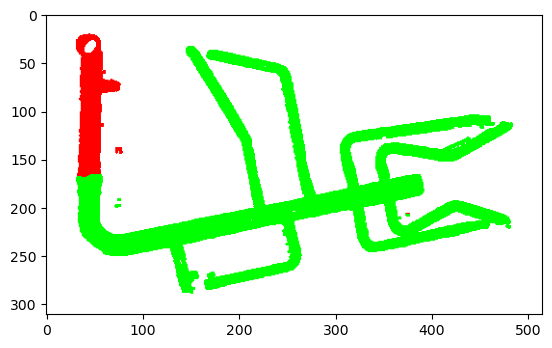

In [5]:
N_SIZE = 10

output = image.copy()

for x in range(len(image[0])):
    for y in range(len(image)):
        colorx = tuple(list(image[y][x]))
        if colorx == (255, 255, 255):
            continue
        
        # Record colors around current x, y pixel.
        colors = {}
        
        min_x = max(0, x-N_SIZE)
        max_x = min(len(image[0])-1, x+N_SIZE)
        min_y = max(0, y-N_SIZE)
        max_y = min(len(image)-1, y+N_SIZE)
        
        for x2 in range(min_x, max_x+1):
            for y2 in range(min_y, max_y+1):
                colory = tuple(list(image[y2][x2]))
                if colory == (255, 255, 255):
                    continue
                
                color = str(image[y2, x2])
                if colors.get(color) == None:
                    colors[color] = 1
                else:
                    colors[color] += 1
                
        # Get most dominant color around this pixel.
        colors_sorted = sorted(colors.items(), key=lambda item: item[1], reverse=True)
        color = colors_sorted[0][0]
        color = color[1:len(color)-1]
        color = " ".join(color.split())
        color = color.split(' ')
        color = [int(x) for x in color]
        
#         if tuple(color) != tuple(list(output[y, x])):
#             print('Changing from {} to {}                    {}'.format(list(output[y, x]), color, colors_sorted))
        
        output[y, x] = color
    print('\r', 'Progress: {}%'.format(str(int(x / int(len(image[0])-1) * 100))), end='')
    
manifold_seg = output.copy()
plt.imshow(manifold_seg)

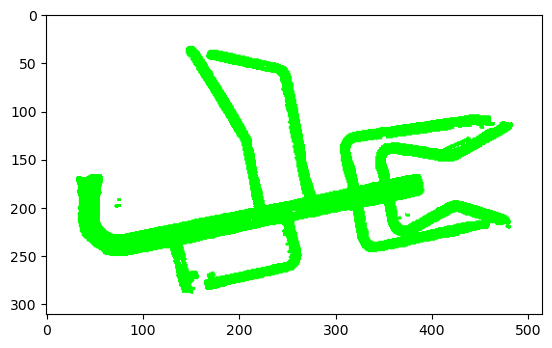

In [6]:
# Naive way of only showing green portion.

color_in = (0, 255, 0)
color_out = (255, 0, 0)

image = manifold_seg.copy()
for x in range(len(image[0])):
    for y in range(len(image)):
        color = tuple(image[y, x])
        if color == color_out:
            image[y, x] = [255, 255, 255]
plt.imshow(image)

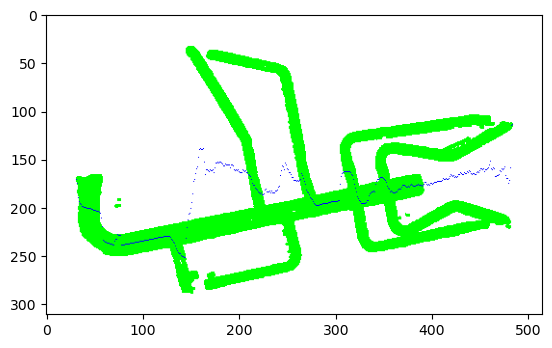

In [7]:
# Take average of y values at each x value to form "orientation line."
x_points = np.array([])
y_points = np.array([])
for x in range(len(image[0])):
    average_y = 0
    count = 0
    for y in range(len(image)):
        color = tuple(image[y, x])
        if color == color_in:
            average_y += y
            count += 1
    if count != 0:
        average_y = int(average_y / count)
    
    if average_y != 0:
        # Add to points that will later create line of best fit.
        x_points = np.append(x_points, [x])
        y_points = np.append(y_points, [average_y])
        
        image[average_y, x] = [0, 0, 255]
        

plt.imshow(image)

In [8]:
# TODO: Develop more sophisticated method for only removing outliers if they are really large outliers.
def reject_outliers(data, x, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m], x[s<m]

y_points, x_points = reject_outliers(y_points, x_points)

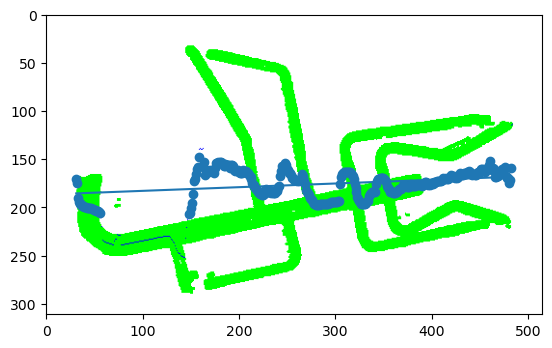

In [12]:
#find line of best fit
a, b = np.polyfit(x_points, y_points, 1)

plt.gca().invert_yaxis()

# Plot manifold
#   Note: This is important to get the correct figure size.
plt.imshow(image)

#add points to plot
plt.scatter(x_points, y_points)

#add line of best fit to plot
plt.plot(x_points, a*x_points+b)
plt.xlim(left=0, right=len(image[0]))
plt.ylim(top=0, bottom=len(image))
plt.show()

In [10]:
# import cv2 as cv
# from math import atan2, cos, sin, sqrt, pi
# import numpy as np
 
# def drawAxis(img, p_, q_, color, scale):
#   p = list(p_)
#   q = list(q_)
 
#   ## [visualization1]
#   angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
#   hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
 
#   # Here we lengthen the arrow by a factor of scale
#   q[0] = p[0] - scale * hypotenuse * cos(angle)
#   q[1] = p[1] - scale * hypotenuse * sin(angle)
#   cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)
 
#   # create the arrow hooks
#   p[0] = q[0] + 9 * cos(angle + pi / 4)
#   p[1] = q[1] + 9 * sin(angle + pi / 4)
#   cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)
 
#   p[0] = q[0] + 9 * cos(angle - pi / 4)
#   p[1] = q[1] + 9 * sin(angle - pi / 4)
#   cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)
#   ## [visualization1]
 
# def getOrientation(pts, img):
#   ## [pca]
#   # Construct a buffer used by the pca analysis
#   sz = len(pts)
#   data_pts = np.empty((sz, 2), dtype=np.float64)
#   for i in range(data_pts.shape[0]):
#     data_pts[i,0] = pts[i,0,0]
#     data_pts[i,1] = pts[i,0,1]
 
#   # Perform PCA analysis
#   mean = np.empty((0))
#   mean, eigenvectors, eigenvalues = cv.PCACompute2(data_pts, mean)
 
#   # Store the center of the object
#   cntr = (int(mean[0,0]), int(mean[0,1]))
#   ## [pca]
 
#   ## [visualization]
#   # Draw the principal components
#   cv.circle(img, cntr, 3, (255, 0, 255), 2)
#   p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
#   p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
#   drawAxis(img, cntr, p1, (255, 255, 0), 1)
#   drawAxis(img, cntr, p2, (0, 0, 255), 5)
 
#   angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
#   ## [visualization]
 
#   # Label with the rotation angle
#   label = "  Rotation Angle: " + str(-int(np.rad2deg(angle)) - 90) + " degrees"
#   textbox = cv.rectangle(img, (cntr[0], cntr[1]-25), (cntr[0] + 250, cntr[1] + 10), (255,255,255), -1)
#   cv.putText(img, label, (cntr[0], cntr[1]), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv.LINE_AA)
 
#   return angle
 
# # Load the image
# img = image.copy() #cv.imread("manifolds/manifold1.png")
 
# # Was the image there?
# if img is None:
#   print("Error: File not found")
#   exit(0)
 
# cv.imshow('Input Image', img)
 
# # Convert image to grayscale
# gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
 
# # Convert image to binary
# _, bw = cv.threshold(gray, 50, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
 
# # Find all the contours in the thresholded image
# contours, _ = cv.findContours(bw, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
 
# for i, c in enumerate(contours):
 
#   # Calculate the area of each contour
#   area = cv.contourArea(c)
 
#   # Ignore contours that are too small or too large
#   if area < 3700 or 100000 < area:
#     continue
 
#   # Draw each contour only for visualisation purposes
#   cv.drawContours(img, contours, i, (0, 0, 255), 2)
 
#   # Find the orientation of each shape
#   getOrientation(c, img)
 
# cv.imshow('Output Image', img)
# cv.waitKey(0)
# cv.destroyAllWindows()
  
# # Save the output image to the current directory
# cv.imwrite("output_img.jpg", img)

In [11]:
# Take average along x axis as well, then combine these with respective y to get the average of (x, y) values.
#   Don't understand this ^

# Take centroids in center of manifolds instead of average across x/y axes, then line of best fit through these?